In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

import scipy.optimize as sci_opt
import yfinance as yf
import pandas_datareader
import datetime as dt

sns.set()
# based on https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb

### Importing S&P 500 stocks

- We start by reading and print the stock tickers that make up S&P500

In [72]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


- There are some issues with BF.B and BRK.B, as we need to replace the . with -.
- Let us remedy this:


In [80]:
k1, k2 = 0, 0
for j in range(503):
    if tickers.Symbol[j] == 'BF.B':
        k1 = j
    if tickers.Symbol[j] == 'BRK.B':
        k2 = j

tickers.Symbol[k1] = 'BF-B'
tickers.Symbol[k2] = 'BRK-B'

tickers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             493 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


- We get the data for this tickers from yahoo finance:

In [81]:
data = yf.download(tickers.Symbol.to_list(),'2018-06-01','2023-06-01', auto_adjust=True)['Close']

[*********************100%***********************]  503 of 503 completed


In [82]:
data.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-01,60.490120,43.068272,119.222000,45.451923,77.643875,76.989494,57.487221,26.610001,147.941360,251.309998,...,182.148148,38.552917,63.167854,41.372868,67.617538,74.937889,105.217590,152.490005,47.720818,82.713593
2018-06-04,61.068253,43.910057,120.680443,45.831799,78.475327,77.894829,58.049107,26.900000,148.444153,253.339996,...,172.998138,38.035881,62.503998,41.868347,67.259888,75.285515,106.198700,153.300003,48.089481,82.684555
2018-06-05,61.203140,43.244457,120.717606,46.185398,78.586197,78.329010,58.058315,27.026667,148.900406,252.699997,...,167.368118,37.329281,62.280132,40.296146,67.448120,75.852768,105.712837,156.779999,47.823704,82.074516
2018-06-06,62.812241,43.254242,121.312119,46.345478,79.172195,80.509171,58.528088,27.200001,151.498123,253.949997,...,169.856689,36.493423,63.345390,40.982201,68.351692,76.493172,106.684547,158.979996,48.998287,82.762009
2018-06-07,62.850761,42.911655,120.810524,46.221237,78.649551,80.001083,58.196484,27.213333,149.542816,247.509995,...,166.772003,36.812252,63.978401,41.077492,68.812889,77.023804,106.208038,158.169998,48.835388,82.945999


In [83]:
data.to_csv('AllSP500.csv')

### Weights in the S&P 500 index

- We import the weights from https://www.slickcharts.com/sp500. These are saved in the sp500.csv file.

In [89]:
sp500_ws = pd.read_csv('sp500.csv')
sp500_ws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Company  503 non-null    object 
 1   Symbol   503 non-null    object 
 2   Weight   503 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.9+ KB


In [38]:
sp500_ws.head()

,Company,Symbol,Weight
0,Apple Inc,AAPL,7.466181
1,Microsoft Corp,MSFT,6.860771
2,Amazon.com Inc,AMZN,3.064611
3,Nvidia Corp,NVDA,2.957218
4,Tesla Inc,TSLA,2.018166


In [9]:
sp500_ws.tail()

,Company,Symbol,Weight
498,Fox Corp Class B,FOX,0.011471
499,Lincoln National Corp,LNC,0.009356
500,Newell Brands Inc,NWL,0.008696
501,News Corp Class B,NWS,0.006489
502,Dish Network Corp A,DISH,0.004361


In [90]:
tickers2 = list(sp500_ws.Symbol)

Text(0, 0.5, 'Weight %')

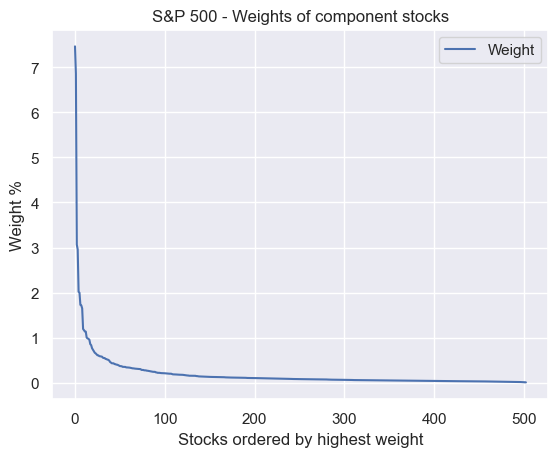

In [91]:
sp500_ws.plot()

# Give the Plot some labels, and titles.
plt.title('S&P 500 - Weights of component stocks')
plt.xlabel('Stocks ordered by highest weight')
plt.ylabel('Weight %')


- It appears that some a small number of stocks have large weights, while the remaining ones have very small contributions. For instance, the 'top' 10 stocks already give a total weight of:

In [92]:
sp500_ws.Weight[:10].sum()

30.648794

- Let us have a quick look at these components:

In [93]:
sp500_first10 = sp500_ws[:10]
sp500_first10.loc[10] = ['Other', 'Other', 100-sp500_ws.Weight[:10].sum()]
sp500_first10

,Company,Symbol,Weight
0,Apple Inc,AAPL,7.466181
1,Microsoft Corp,MSFT,6.860771
2,Amazon.com Inc,AMZN,3.064611
3,Nvidia Corp,NVDA,2.957218
4,Tesla Inc,TSLA,2.018166
5,Alphabet Inc Cl A,GOOGL,1.996184
6,Alphabet Inc Cl C,GOOG,1.727553
7,Meta Platforms Inc Class A,META,1.716800
8,Berkshire Hathaway Inc Cl B,BRK-B,1.648476
9,Unitedhealth Group Inc,UNH,1.192834


In [94]:
sp500_first10 = sp500_first10.drop(['Company'], axis=1)
sp500_first10 = sp500_first10.set_index('Symbol')
sp500_first10 = sp500_first10.reset_index()

sp500_first10

,Symbol,Weight
0,AAPL,7.466181
1,MSFT,6.860771
2,AMZN,3.064611
3,NVDA,2.957218
4,TSLA,2.018166
5,GOOGL,1.996184
6,GOOG,1.727553
7,META,1.716800
8,BRK-B,1.648476
9,UNH,1.192834


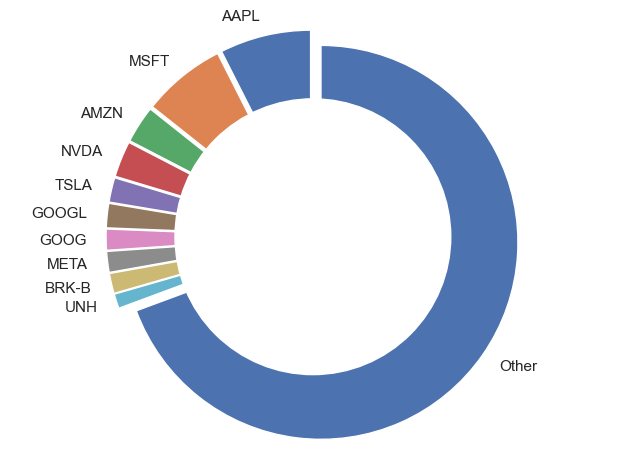

In [95]:
data = list(sp500_first10.Weight)
labels = list(sp500_first10.Symbol)

myexplode = [0.05]*11

fig1, ax1 = plt.subplots()
plt.pie(data, labels = labels, startangle=90, pctdistance=0.85, explode = myexplode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()
 

### Grouping stocks by sector

- We would now like to group stocks by sector and analyze the returns of each sector.
- There are 11 sectors, as can be seen below:

In [96]:
sectors = tickers['GICS Sector'].unique()
sectors

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

In [98]:
tickers = tickers.set_index('Symbol')
tickers.head()

,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Symbol,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


- Now, we add the sector to the sp500_ws dataframe, as follows:

In [99]:
sectors = []

for j in range(503):
    sectors.append(tickers.loc[sp500_ws.loc[j]['Symbol']]['GICS Sector'])

sp500_ws['Sector'] = sectors
sp500_ws.head()

,Company,Symbol,Weight,Sector
0,Apple Inc,AAPL,7.466181,Information Technology
1,Microsoft Corp,MSFT,6.860771,Information Technology
2,Amazon.com Inc,AMZN,3.064611,Consumer Discretionary
3,Nvidia Corp,NVDA,2.957218,Information Technology
4,Tesla Inc,TSLA,2.018166,Consumer Discretionary


In [100]:
sp500_ws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Company  503 non-null    object 
 1   Symbol   503 non-null    object 
 2   Weight   503 non-null    float64
 3   Sector   503 non-null    object 
dtypes: float64(1), object(3)
memory usage: 15.8+ KB


In [101]:
sectors = tickers['GICS Sector'].unique()

my_dict = {}
    
for sec in sectors:
    my_dict[sec] = 0

for j in range(503):
    my_dict[sp500_ws.iloc[j]['Sector']] += sp500_ws.iloc[j]['Weight']
    
my_dict

{'Industrials': 8.392827999999998,
 'Health Care': 13.477684999999994,
 'Information Technology': 28.37111000000001,
 'Communication Services': 8.521889999999997,
 'Consumer Staples': 6.697243000000001,
 'Consumer Discretionary': 10.634793999999998,
 'Utilities': 2.6235370000000007,
 'Financials': 12.410525999999996,
 'Materials': 2.4586280000000005,
 'Real Estate': 2.3813150000000003,
 'Energy': 4.0315069999999995}

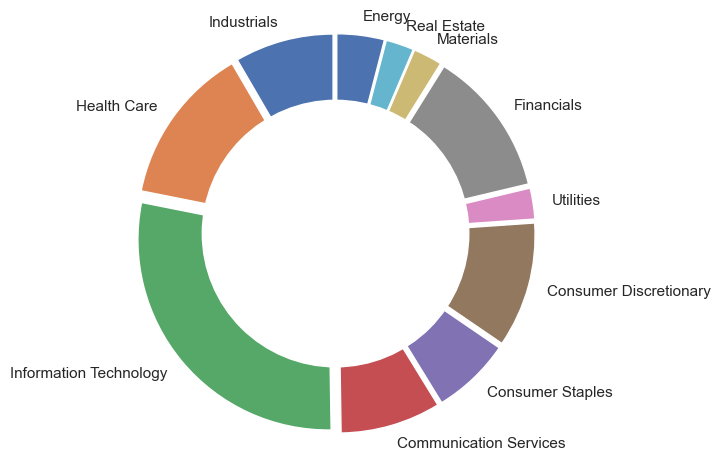

In [102]:
# Get the Keys and store them in a list
labels = list(my_dict.keys())

# Get the Values and store them in a list
values = list(my_dict.values())

myexplode = [0.05]*11

fig1, ax1 = plt.subplots()
plt.pie(values, labels = labels, startangle=90, pctdistance=0.85, explode = myexplode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()


### An 'S&P 10' Portfolio

- In the previous section we looked at how the S&P 500 is split among the different sectors, and what are the largest contributors to the index fund.
- The S&P 500 index is a market capitalization-weighted index, meaning that the weights are determined by the market cap of the companies.

    - Weighting in S&P Index = Company Market Capitalization / S&P 500 Total Market Capitalization.
    

- Hence, there should clearly be better ways of designing a portfolio with better returns, compared to the S&P 500.
- Here, we will look at building a portfolio that maximizes the Sharpe Ratio! However, running such an optimization problem for around 500 stocks would take a rather long time. Thus, we will reduce the problem to the 10 largest stocks only, and see how the weights differ. 
- First, a capitalization-weighted 'S&P 10' index would look as follows:


In [103]:
sp500_first10 = sp500_ws[:10]
sp500_first10.Weight = sp500_first10.Weight/sp500_ws.Weight[:10].sum()*100
sp500_first10

,Company,Symbol,Weight,Sector
0,Apple Inc,AAPL,24.360440,Information Technology
1,Microsoft Corp,MSFT,22.385125,Information Technology
2,Amazon.com Inc,AMZN,9.999124,Consumer Discretionary
3,Nvidia Corp,NVDA,9.648725,Information Technology
4,Tesla Inc,TSLA,6.584814,Consumer Discretionary
5,Alphabet Inc Cl A,GOOGL,6.513092,Communication Services
6,Alphabet Inc Cl C,GOOG,5.636610,Communication Services
7,Meta Platforms Inc Class A,META,5.601525,Communication Services
8,Berkshire Hathaway Inc Cl B,BRK-B,5.378600,Financials
9,Unitedhealth Group Inc,UNH,3.891944,Health Care


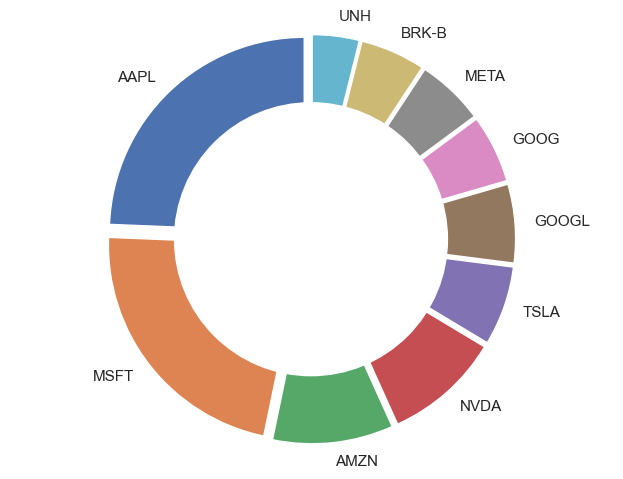

In [104]:
data = list(sp500_first10.Weight)
labels = list(sp500_first10.Symbol)

myexplode = [0.05]*10

fig1, ax1 = plt.subplots()
plt.pie(data, labels = labels, startangle=90, pctdistance=0.85, explode = myexplode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()
 

- Now, let us take the stock data for these 10 stocks, and build a portfolio that maximizes Sharpe Ratio.

In [107]:
data = pd.read_csv('AllSP500.csv')
labels = ['Date'] + labels
data = data[labels]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   AAPL    1258 non-null   float64
 2   MSFT    1258 non-null   float64
 3   AMZN    1258 non-null   float64
 4   NVDA    1258 non-null   float64
 5   TSLA    1258 non-null   float64
 6   GOOGL   1258 non-null   float64
 7   GOOG    1258 non-null   float64
 8   META    1258 non-null   float64
 9   BRK-B   1258 non-null   float64
 10  UNH     1258 non-null   float64
dtypes: float64(10), object(1)
memory usage: 108.2+ KB


In [108]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,AAPL,MSFT,AMZN,NVDA,TSLA,GOOGL,GOOG,META,BRK-B,UNH
0,2018-06-01,45.451923,95.326950,82.077003,63.816803,19.454666,56.750000,55.974998,193.990005,192.229996,225.197464
1,2018-06-04,45.831799,96.159256,83.263496,65.607826,19.782667,57.652000,56.964500,193.279999,191.300003,226.381973
2,2018-06-05,46.185398,96.651093,84.817497,65.662315,19.408667,57.550999,56.983002,192.940002,190.770004,226.196899
3,2018-06-06,46.345478,96.934830,84.787498,65.682137,21.299999,57.347500,56.844002,191.339996,193.990005,230.102081
4,2018-06-07,46.221237,95.412079,84.464996,65.124779,21.072666,56.721001,56.193001,188.179993,195.570007,230.407501


In [111]:
data = data.set_index(['Date'])
data_change = data.pct_change()[1:]
data_change.head()

,AAPL,MSFT,AMZN,NVDA,TSLA,GOOGL,GOOG,META,BRK-B,UNH
Date,,,,,,,,,,
2018-06-04,0.008358,0.008731,0.014456,0.028065,0.016860,0.015894,0.017678,-0.003660,-0.004838,0.005260
2018-06-05,0.007715,0.005115,0.018664,0.000831,-0.018905,-0.001752,0.000325,-0.001759,-0.002771,-0.000818
2018-06-06,0.003466,0.002936,-0.000354,0.000302,0.097448,-0.003536,-0.002439,-0.008293,0.016879,0.017265
2018-06-07,-0.002681,-0.015709,-0.003804,-0.008486,-0.010673,-0.010925,-0.011452,-0.016515,0.008145,0.001327
2018-06-08,-0.009098,0.007435,-0.003143,-0.002359,0.004967,-0.001507,-0.002661,0.004889,0.002250,0.006828


- The Sharpe Ratio is defined as:
$$S_P = \frac{\mathbb{E}[R_P]}{\sigma_P} = \left( \sum_j \mathbb{E}[R_j]\, w_j \right) \left(\sum_{i,j} w_i\, \Sigma_{ij} \, w_j\right)^{-1/2}$$
- Note, however, that $\mathbb{E}[R_P]$ won't make much sense, as the $R_i$ are NOT additive. Thus, we use instead the Log returns, which are additive.

In [112]:
number_of_symbols = 10
log_return = np.log(1 + data_change)

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
# This is the covariance matrix!
exp_vol = np.sqrt(np.dot(rebalance_weights.T, np.dot(log_return.cov() * 252, rebalance_weights)))

# Calculate the Sharpe Ratio (without risk-free ratio)
sharpe_ratio = exp_ret / exp_vol

In [113]:
sharpe_ratio

0.7180121133990381

- So our 'S&P 10' portfolio is in fact not a great one. Can we do better?

### Sharpe Ratio Optimization

- We define some functions to use for our optimization: the get_metrics() function will return the metrics for a given set of weights provided. The function is the neg_sharpe function will be used as a minimization function. The minimization function is used to help find the values which results in the lowest sharpe ratio. In Scipy’s optimize function, there’s no maximize, so as an objective function you need to pass something that should be minimized.

- The third function is check_sum function which is used as a constraint. What it will do is make sure that the weights that are passed through meet the constraint that we must have a portfolio allocation equal 100%, not more and not less.

In [115]:
def get_metrics(weights: list) -> np.array:
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252 # Calculate the returns, annualize them (252).

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
        )

    sr = ret / vol # Calculate the Sharpe Ratio.
    return np.array([ret, vol, sr])


def grab_negative_sharpe(weights: list) -> np.array:
    return -get_metrics(weights)[2]  # negative sharpe ratio 


def check_sum(weights: list) -> float:
    return np.sum(weights) - 1


- Okay with our functions now defined, let's run the optimization using the scipy.optimization module. This module has a function called minimize which we can use to help our optimial values. However, we need to do a few things before we run it. First, we need to define bounds which tells the minimize function that each of our positions can only be between 0% and 100% of the allocation. Second, we need to define the constraint which will be a fun(function) that ensures we equ(equal) a 100% allocated portfolio. In other words, we use all the "capital" we can. Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case let's make it easy and start with an equally distirbuted portofolio. In this case we have 10 symbols so each symbol will be 1/10 of the portfolio.

- Once we've defined this steps we can run the optimization by passing through the arguments defined and defining the method as SLSQP which is short for Sequential Least Squares Programming. Now, the different optimization methods are a whole different topic and is outside the scope of this tutorial. Once we run the minimize method we can grab the results.

- The first is the results of our minimization operation. Inside the results, you'll see the optimize sharpe ration defined by the fun value. We can then take the optimized_weights defined by the optimized_sharpe.x values, and use them to return the different metrics we have for our portfolio.

In [116]:
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})
 
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP', # Sequential Least Squares Programming
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.9224066064842398
       x: [ 3.718e-01  3.115e-01  6.939e-18  5.927e-03  1.919e-01
            8.674e-18  1.343e-17  4.640e-17  2.255e-17  1.189e-01]
     nit: 10
     jac: [ 2.607e-04 -8.488e-05  4.936e-01  1.806e-04  9.341e-05
            2.031e-01  1.878e-01  5.890e-01  6.769e-02 -7.526e-04]
    nfev: 111
    njev: 10
--------------------------------------------------------------------------------


- So we get a sharpe ratio of 0.922. This is still not great, but better than the 'S&P 10' Portfolio!
- Let's visualize this!

In [140]:
get_metrics(optimized_sharpe.x)

array([0.28947673, 0.31382769, 0.92240661])

In [133]:
sp500_first10['New_weights'] = optimized_sharpe.x*100       
sp500_first10.sort_values(by=['New_weights'])

,Company,Symbol,Weight,Sector,New_weights
2,Amazon.com Inc,AMZN,9.999124,Consumer Discretionary,6.938894e-16
5,Alphabet Inc Cl A,GOOGL,6.513092,Communication Services,8.673617e-16
6,Alphabet Inc Cl C,GOOG,5.636610,Communication Services,1.343394e-15
8,Berkshire Hathaway Inc Cl B,BRK-B,5.378600,Financials,2.255141e-15
7,Meta Platforms Inc Class A,META,5.601525,Communication Services,4.640385e-15
3,Nvidia Corp,NVDA,9.648725,Information Technology,5.927457e-01
9,Unitedhealth Group Inc,UNH,3.891944,Health Care,1.188765e+01
4,Tesla Inc,TSLA,6.584814,Consumer Discretionary,1.918537e+01
1,Microsoft Corp,MSFT,22.385125,Information Technology,3.115091e+01
0,Apple Inc,AAPL,24.360440,Information Technology,3.718333e+01


- The two portfolios are quite different!

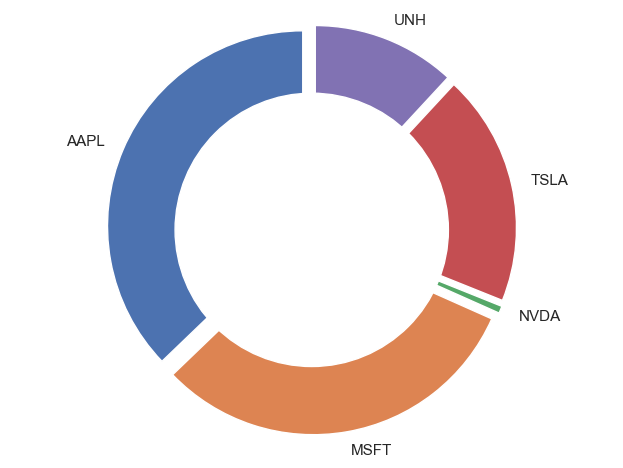

In [137]:
data, labels = [], []

for j in range(10):
    if sp500_first10['New_weights'][j] > 0.001:
        data.append(sp500_first10['New_weights'][j])
        labels.append(sp500_first10['Symbol'][j])

myexplode = [0.05]*len(data)

fig1, ax1 = plt.subplots()
plt.pie(data, labels = labels, startangle=90, pctdistance=0.85, explode = myexplode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

### Monte Carlo Simulation

- Finally, let us do a Monte Carlo simulation for finding the Sharpe Ratio. This is purely for visualization purposes.

In [142]:
# Initialize the components, to run a Monte Carlo Simulation.

num_of_portfolios = 30000

all_weights = np.zeros((num_of_portfolios, number_of_symbols))
ret_arr = np.zeros(num_of_portfolios) # array of returns
vol_arr = np.zeros(num_of_portfolios) # array of volatilities
sharpe_arr = np.zeros(num_of_portfolios) # array of sharpe ratio

for ind in range(num_of_portfolios):

    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    all_weights[ind, :] = weights  
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]
simulations_df = pd.DataFrame(data=simulations_data).T
simulations_df.columns = ['Returns','Volatility','Sharpe Ratio','Portfolio Weights']

simulations_df = simulations_df.infer_objects()


simulations_df.head()

,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.205807,0.290008,0.709659,"[0.1364340389262313, 0.17335468280840186, 0.01..."
1,0.145580,0.251957,0.577797,"[0.0578973493127729, 0.06284147838080446, 0.19..."
2,0.173709,0.283540,0.612644,"[0.1027024242325892, 0.08410217130099731, 0.13..."
3,0.178187,0.301326,0.591342,"[0.024166953917849447, 0.04622651267612032, 0...."
4,0.189136,0.276166,0.684863,"[0.07337618337992105, 0.08412743216960757, 0.0..."


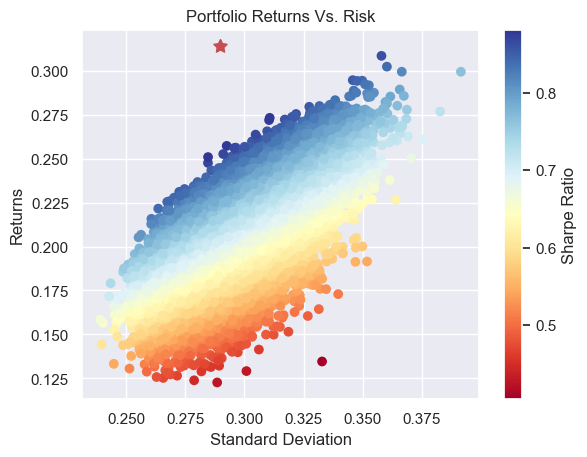

In [143]:
# Plot the data on a Scatter plot.
plt.scatter(y=simulations_df['Returns'], x=simulations_df['Volatility'], c=simulations_df['Sharpe Ratio'], cmap='RdYlBu')

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio portfolio found before
plt.scatter(0.28947673, 0.31382769, marker=(5, 1, 0), color='r', s=100) # s=size

# Finally, show the plot.
plt.show()

- Note that we are actually missing out on the maximal Sharpe Ratio due to the fact that a bunch of the weights are actually zero!